In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

import warnings
warnings.filterwarnings("ignore")

In [11]:
# breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

# for imgname in breast_img[:3]:
#     print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


In [ ]:
# glob.glob(f'{data_path}/**/*.png', recursive=True)

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

2024-06-23 19:42:42.910408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 19:42:42.910501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 19:42:43.044628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pickle

# Path to the serialized object
file_path = '/kaggle/input/histopathology-breast-images-lists/breast_img_list.pkl'

# Deserializing the list
with open(file_path, 'rb') as file:
    loaded_breast_img = pickle.load(file)

In [3]:
breast_img = loaded_breast_img

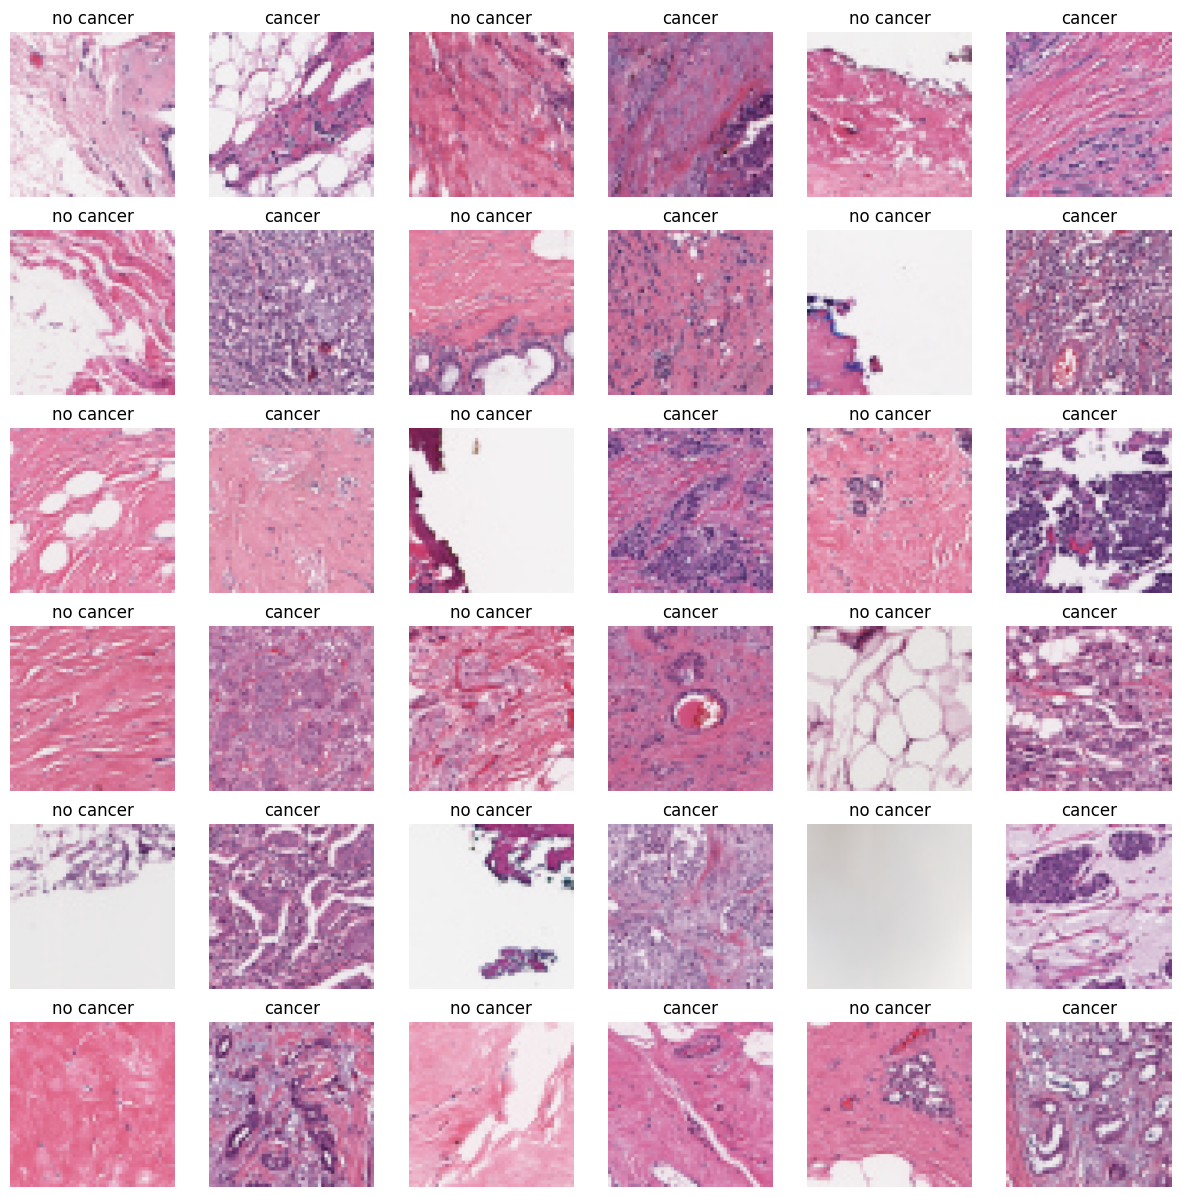

In [4]:


class BreastHistopathology:
    def __init__(self, data_path, breast_image):
        self.data_path = data_path
        self.breast_img = breast_image
        self.Negative_Cases = []
        self.Positive_Cases = []
        self.load_data()

    def load_data(self):
        for img in self.breast_img:
            if img[-5] == '0':
                self.Negative_Cases.append(img)
            elif img[-5] == '1':
                self.Positive_Cases.append(img)

    def visualize_sample_images(self):
        plt.figure(figsize=(15, 15))
        some_non = np.random.randint(0, len(self.Negative_Cases), 18)
        some_can = np.random.randint(0, len(self.Positive_Cases), 18)

        for i, num in enumerate(some_non):
            img = image.load_img((self.Negative_Cases[num]), target_size=(100, 100))
            img = image.img_to_array(img)
            plt.subplot(6, 6, 2*i+1)
            plt.axis('off')
            plt.title('no cancer')
            plt.imshow(img.astype('uint8'))

        for i, num in enumerate(some_can):
            img = image.load_img((self.Positive_Cases[num]), target_size=(100, 100))
            img = image.img_to_array(img)
            plt.subplot(6, 6, 2*i+2)
            plt.axis('off')
            plt.title('cancer')
            plt.imshow(img.astype('uint8'))

    def prepare_dataset(self):
        non_img_arr = [self.process_image(img, 0) for img in self.Negative_Cases[:78786]]
        can_img_arr = [self.process_image(img, 1) for img in self.Positive_Cases]
        
        min_size = min(len(non_img_arr), len(can_img_arr))
        breast_img_arr = np.array(non_img_arr[:min_size] + can_img_arr[:min_size], dtype=object)
        
        np.random.shuffle(breast_img_arr)
        X = np.array([item[0] for item in breast_img_arr])
        y = np.array([item[1] for item in breast_img_arr])
        return X, y

    def process_image(self, img_path, label):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
        return [img_resized, label]

    def split_data(self, X, y):
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)
        Y_train = to_categorical(Y_train, num_classes=2)
        Y_test = to_categorical(Y_test, num_classes=2)
        return X_train, X_test, Y_train, Y_test

    def describe_data(self, X, y):
        print('Total number of images:', len(X))
        print('Number of Non-Cancer Cases:', np.sum(y == 0))
        print('Number of Cancer Cases:', np.sum(y == 1))
        print('Image shape (Width, Height, Channels):', X[0].shape)


# Example usage:
dataset = BreastHistopathology('/kaggle/input/breast-histopathology-images', breast_img)
dataset.visualize_sample_images()


In [ ]:
X, y = dataset.prepare_dataset()
X_train, X_test, Y_train, Y_test = dataset.split_data(X, y)
dataset.describe_data(X, y)

In [18]:
dataset.describe_data(X, y)

Total number of images: 157572
Number of Non-Cancer Cases: 78786
Number of Cancer Cases: 78786
Image shape (Width, Height, Channels): (50, 50, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


def build_model(backbone_name='EfficientNetV2B0', input_shape=(50, 50, 3), num_classes=2, reg_factor=0.02):
    backbones = {
        'EfficientNetV2B0': EfficientNetV2B0,
        'EfficientNetV2B1': EfficientNetV2B1,
        'MobileNetV2': MobileNetV2,
        'InceptionV3': InceptionV3,
        'ResNet50': ResNet50
    }

    BackboneModel = backbones[backbone_name]
    backbone = BackboneModel(include_top=False, input_shape=input_shape, weights='imagenet', pooling='avg')
    backbone.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = backbone(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(reg_factor))(x)
    x = layers.Dropout(0.5)(x)  # Additional dropout
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(reg_factor))(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'auc'])
    return model




In [16]:
# Example: Build and compile the model with EfficientNetV2B0
model_eff_net_b0 = build_model('EfficientNetV2B0')
model_eff_net_b0.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,089,170 (23.23 MB)

 Trainable params: 6,025,746 (22.99 MB)

 Non-trainable params: 63,424 (247.75 KB)

In [19]:
model_mob_net_v2 = build_model('MobileNetV2')
model_mob_net_v2.summary()

/tmp/ipykernel_34/3271996092.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = BackboneModel(include_top=False, input_shape=input_shape, weights='imagenet', pooling='avg')


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,842 (9.26 MB)

 Trainable params: 2,390,914 (9.12 MB)

 Non-trainable params: 36,928 (144.25 KB)

In [9]:
model_res_net50 = build_model('ResNet50')
model_res_net50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,946 (91.01 MB)

 Trainable params: 23,801,474 (90.80 MB)

 Non-trainable params: 57,472 (224.50 KB)

In [20]:
# Callbacks
callbacks_mob_net= [
ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
ModelCheckpoint('best_model_mobnetv3.keras', monitor='val_loss', save_best_only=True, verbose=1 ) 
]

In [11]:
# Callbacks
callbacks_eff_net_b0= [
ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
ModelCheckpoint('best_model_eff_netb0.keras', monitor='val_loss', save_best_only=True, verbose=1 ) 
]

In [12]:
# Callbacks
callbacks_res_net_50= [
ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
ModelCheckpoint('best_model_res_net50.keras', monitor='val_loss', save_best_only=True, verbose=1 ) 
]

In [13]:
try:
    history_eff_net_b0 = model_eff_net_b0.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=callbacks_eff_net_b0)
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/40
   1/2522 ━━━━━━━━━━━━━━━━━━━━ 75:05:02 107s/step - accuracy: 0.5429 - auc: 0.6294 - loss: 5.6445

I0000 00:00:1719173155.378608     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8089 - auc: 0.8813 - loss: 1.2884
Epoch 1: val_loss improved from inf to 0.34516, saving model to best_model_eff_netb0.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 269s 64ms/step - accuracy: 0.8089 - auc: 0.8813 - loss: 1.2882 - val_accuracy: 0.8781 - val_auc: 0.9481 - val_loss: 0.3452 - learning_rate: 0.0010
Epoch 2/40
2521/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8663 - auc: 0.9359 - loss: 0.3855
Epoch 2: val_loss did not improve from 0.34516
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.8663 - auc: 0.9359 - loss: 0.3855 - val_accuracy: 0.8674 - val_auc: 0.9394 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 3/40
2521/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8687 - auc: 0.9356 - loss: 0.3901
Epoch 3: val_loss did not improve from 0.34516
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.8687 - auc: 0.9356 - loss: 0.3901 - val_accuracy: 0.8732 - val_auc: 0.9416 - val_loss: 0.4523 - learnin

In [21]:
try:
    history_mobnetv2 = model_mob_net_v2.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=callbacks_mob_net)
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7859 - auc: 0.8609 - loss: 1.2393
Epoch 1: val_loss improved from inf to 3.56222, saving model to best_model_mobnetv3.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 121s 31ms/step - accuracy: 0.7859 - auc: 0.8610 - loss: 1.2391 - val_accuracy: 0.5044 - val_auc: 0.5066 - val_loss: 3.5622 - learning_rate: 0.0010
Epoch 2/40
2520/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8603 - auc: 0.9302 - loss: 0.3936
Epoch 2: val_loss improved from 3.56222 to 3.39841, saving model to best_model_mobnetv3.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.8603 - auc: 0.9302 - loss: 0.3936 - val_accuracy: 0.5011 - val_auc: 0.5011 - val_loss: 3.3984 - learning_rate: 0.0010
Epoch 3/40
2521/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8650 - auc: 0.9338 - loss: 0.3886
Epoch 3: val_loss improved from 3.39841 to 1.70851, saving model to best_model_mobnetv3.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0

In [ ]:
try:
    history_resnet50 = model_res_net50.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=callbacks_res_net_50)
except KeyboardInterrupt:
    print("\nTraining Stopped!")

In [ ]:
try:
    history_resnet50 = model_res_net50.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=callbacks_res_net_50)
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/40
   4/2522 ━━━━━━━━━━━━━━━━━━━━ 1:59 47ms/step - accuracy: 0.5500 - auc: 0.5621 - loss: 24.6433 

W0000 00:00:1719010072.754904     193 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8109 - auc: 0.8799 - loss: 1.9039

W0000 00:00:1719010221.366478     191 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 173.38695, saving model to best_model_res_net50.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 238s 65ms/step - accuracy: 0.8109 - auc: 0.8799 - loss: 1.9035 - val_accuracy: 0.6079 - val_auc: 0.5773 - val_loss: 173.3869 - learning_rate: 0.0010
Epoch 2/40
2521/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8415 - auc: 0.9106 - loss: 0.5375
Epoch 2: val_loss improved from 173.38695 to 0.63356, saving model to best_model_res_net50.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 121s 48ms/step - accuracy: 0.8415 - auc: 0.9106 - loss: 0.5375 - val_accuracy: 0.7989 - val_auc: 0.8590 - val_loss: 0.6336 - learning_rate: 0.0010
Epoch 3/40
2521/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8555 - auc: 0.9223 - loss: 0.5106
Epoch 3: val_loss did not improve from 0.63356
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 116s 46ms/step - accuracy: 0.8555 - auc: 0.9223 - loss: 0.5106 - val_accuracy: 0.7583 - val_auc: 0.8146 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 4/40
2522/2522

In [32]:
# try:
#     history_eff_net_b0 = model_eff_net_b0.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=callbacks_eff_net_b0)
# except KeyboardInterrupt:
#     print("\nTraining Stopped!")

Epoch 1/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8105 - auc: 0.8821 - loss: 2.1904
Epoch 1: val_loss improved from inf to 0.41307, saving model to best_model_eff_netb0.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 316s 76ms/step - accuracy: 0.8105 - auc: 0.8821 - loss: 2.1899 - val_accuracy: 0.8755 - val_auc: 0.9463 - val_loss: 0.4131 - learning_rate: 0.0010
Epoch 2/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8673 - auc: 0.9353 - loss: 0.4405
Epoch 2: val_loss improved from 0.41307 to 0.40556, saving model to best_model_eff_netb0.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 101s 40ms/step - accuracy: 0.8673 - auc: 0.9353 - loss: 0.4405 - val_accuracy: 0.8870 - val_auc: 0.9532 - val_loss: 0.4056 - learning_rate: 0.0010
Epoch 3/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8848 - auc: 0.9472 - loss: 0.4246
Epoch 3: val_loss did not improve from 0.40556
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 101s 40ms/step - accuracy: 0.8848 - auc: 0.9472 - loss: 0.4246 - val_ac

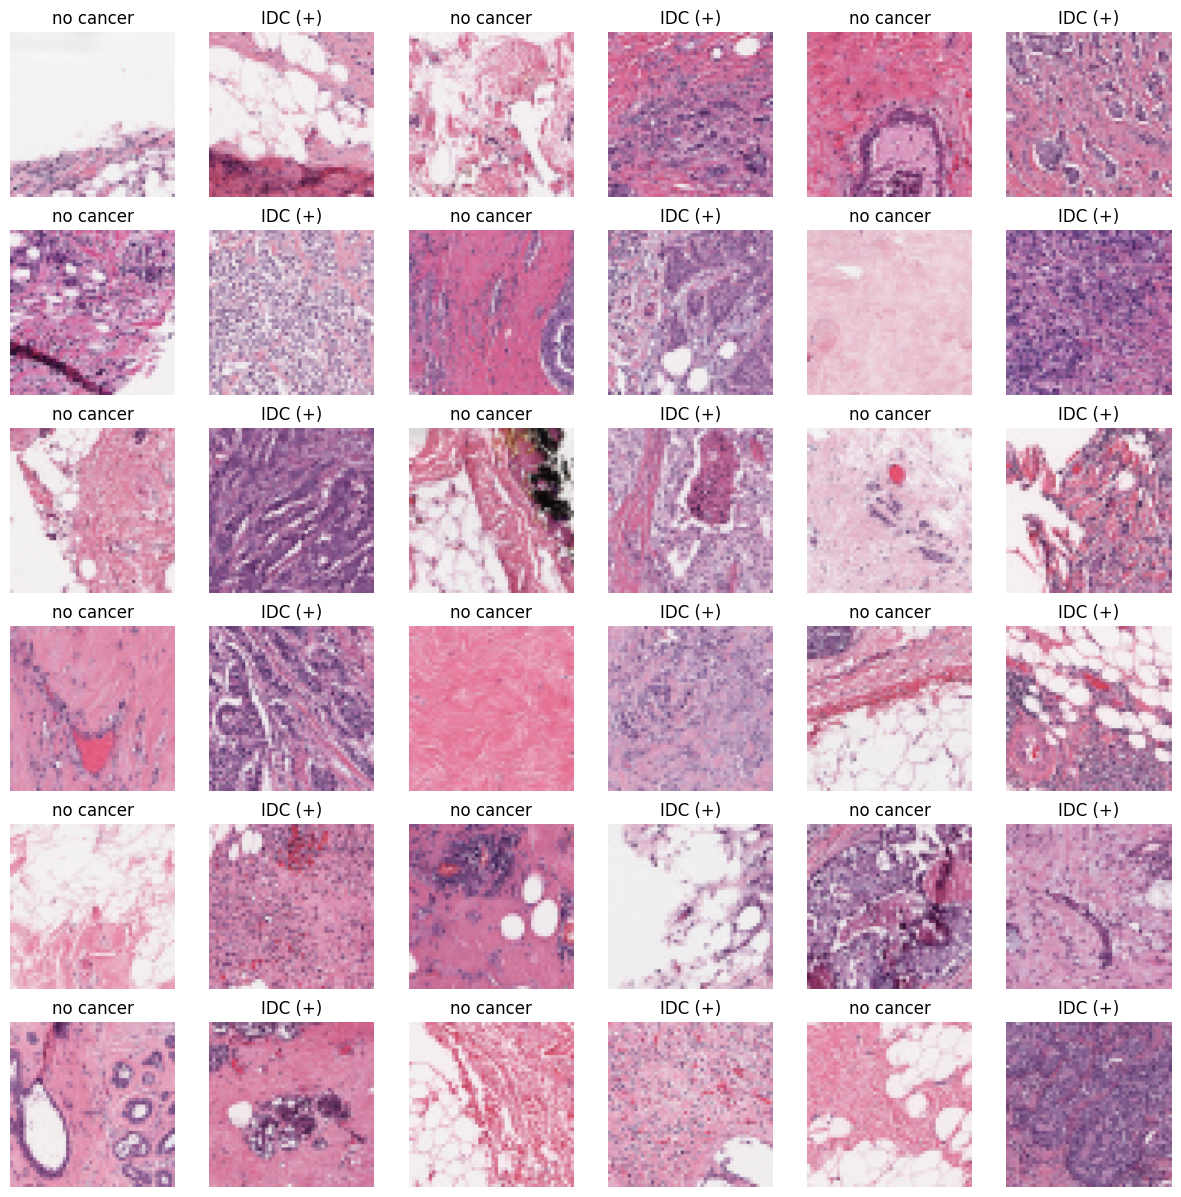

In [4]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [5]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


In [6]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])


In [7]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

78786
78786
157572


In [8]:
min_size = min(len(non_img_arr), len(can_img_arr))
X = []
y = []

breast_img_arr = np.array(non_img_arr[:min_size] + can_img_arr[:min_size], dtype=object)

# Shuffle the combined array
np.random.shuffle(breast_img_arr)

# Separate features and labels
X = np.array([item[0] for item in breast_img_arr])
y = np.array([item[1] for item in breast_img_arr])

# Checking array dimensions
print(X.shape, y.shape)

(157572, 50, 50, 3) (157572,)


In [9]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)


Total number of images: 157572
Number of IDC(-) Images: 78786
Number of IDC(+) Images: 78786
Image shape (Width, Height, Channels): (50, 50, 3)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (110300, 50, 50, 3)
Testing Data Shape: (47272, 50, 50, 3)


In [11]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools


In [47]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 35)

Epoch 1/40


2024-06-18 22:09:37.003779: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 2.36257, expected 2.02498
2024-06-18 22:09:37.003858: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5000: 4.71043, expected 4.10257
2024-06-18 22:09:37.003868: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5012: 4.829, expected 4.22113
2024-06-18 22:09:37.003876: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5016: 4.8818, expected 4.27393
2024-06-18 22:09:37.003884: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5030: 4.47237, expected 3.8645
2024-06-18 22:09:37.003892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5031: 4.71155, expected 4.10368
2024-06-18 22:09:37.003900: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5042: 4.68974, expected 4.08187
2024-06-18 22:09:37.003908: E external/l

3145/3152 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7859 - loss: 0.4869

2024-06-18 22:10:06.579706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.63428, expected 3.03472
2024-06-18 22:10:06.579761: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.81927, expected 4.21972
2024-06-18 22:10:06.579776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.64085, expected 4.0413
2024-06-18 22:10:06.579789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.78607, expected 4.18652
2024-06-18 22:10:06.579800: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.66865, expected 4.0691
2024-06-18 22:10:06.579809: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.38936, expected 3.78981
2024-06-18 22:10:06.579819: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.85923, expected 3.25968
2024-06-18 22:10:06.579830: E external/local_xla/xla/serv

3152/3152 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7859 - loss: 0.4868

2024-06-18 22:10:17.043729: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10000: 3.72451, expected 3.14933
2024-06-18 22:10:17.043778: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10006: 4.54495, expected 3.96977
2024-06-18 22:10:17.043787: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10008: 4.50589, expected 3.9307
2024-06-18 22:10:17.043795: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10009: 4.54627, expected 3.97108
2024-06-18 22:10:17.043804: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10010: 4.74206, expected 4.16688
2024-06-18 22:10:17.043812: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10011: 4.62889, expected 4.05371
2024-06-18 22:10:17.043819: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10012: 3.85848, expected 3.2833
2024-06-18 22:10:17.043827: E

3152/3152 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.7859 - loss: 0.4868 - val_accuracy: 0.7858 - val_loss: 0.5086
Epoch 2/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.8274 - loss: 0.4049 - val_accuracy: 0.7423 - val_loss: 0.5663
Epoch 3/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8321 - loss: 0.3906 - val_accuracy: 0.8038 - val_loss: 0.7435
Epoch 4/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8394 - loss: 0.3793 - val_accuracy: 0.8417 - val_loss: 0.3708
Epoch 5/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8408 - loss: 0.3737 - val_accuracy: 0.8420 - val_loss: 0.3710
Epoch 6/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8427 - loss: 0.3694 - val_accuracy: 0.8497 - val_loss: 0.3494
Epoch 7/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8466 - loss: 0.3614 - val_accuracy: 0.8535 - val_loss: 0.3445
Epoch 8/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8488 - loss: 0.3584 - va

In [12]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


def build_model(backbone_name='EfficientNetV2B0', input_shape=(50, 50, 3), num_classes=2):
    # Dictionary of available backbones
    backbones = {
        'EfficientNetV2B0': EfficientNetV2B0,
        'EfficientNetV2B1': EfficientNetV2B1,
        'MobileNetV2': MobileNetV2,
        'InceptionV3': InceptionV3,
        'ResNet50': ResNet50
    }

    # Select the backbone model
    BackboneModel = backbones[backbone_name]
    backbone = BackboneModel(include_top=False, input_shape=input_shape, weights='imagenet')
    backbone.trainable = True

    # Build the model
    inputs = layers.Input(shape=input_shape)
    x = backbone(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'auc'])
    return model


# Example: Build and compile the model with EfficientNetV2B0
model_eff_net_b0 = build_model('EfficientNetV2B0')
model_eff_net_b0.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 2, 2, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,538 (23.21 MB)

 Trainable params: 6,022,930 (22.98 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [17]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


def build_model(backbone_name='EfficientNetV2B0', input_shape=(50, 50, 3), num_classes=2):
    # Dictionary of available backbones
    backbones = {
        'EfficientNetV2B0': EfficientNetV2B0,
        'EfficientNetV2B1': EfficientNetV2B1,
        'MobileNetV2': MobileNetV2,
        'InceptionV3': InceptionV3,
        'ResNet50': ResNet50
    }

    # Select the backbone model
    BackboneModel = backbones[backbone_name]
    backbone = BackboneModel(include_top=False, input_shape=input_shape, weights='imagenet')
    backbone.trainable = True

    # Build the model
    inputs = layers.Input(shape=input_shape)
    x = backbone(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'auc'])
    return model


# Example: Build and compile the model with EfficientNetV2B0
model_mob_net_v2 = build_model('MobileNetV2')
model_mob_net_v2.summary()

/tmp/ipykernel_34/570093095.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = BackboneModel(include_top=False, input_shape=input_shape, weights='imagenet')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,388,098 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
model_eff_net_b0 = build_model('EfficientNetV2B0')
model_eff_net_b0.summary()

In [18]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_mobnetv3.keras',  # Path where the model will be saved
        monitor='val_loss',  # Monitor validation loss to determine the best model
        save_best_only=True,  # Save only the best model
        verbose=1 ) # 

In [ ]:
try:
    history_mobnetv2 = model_mob_net_v2.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=[reduce_lr, model_checkpoint, early_stopping])
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7789 - auc: 0.8467 - loss: 1.1296
Epoch 1: val_loss improved from inf to 2.35419, saving model to best_model_mobnetv3.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 123s 30ms/step - accuracy: 0.7789 - auc: 0.8467 - loss: 1.1294 - val_accuracy: 0.5312 - val_auc: 0.4733 - val_loss: 2.3542 - learning_rate: 0.0010
Epoch 2/40
2520/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8603 - auc: 0.9311 - loss: 0.3490
Epoch 2: val_loss did not improve from 2.35419
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.8603 - auc: 0.9311 - loss: 0.3490 - val_accuracy: 0.6107 - val_auc: 0.6337 - val_loss: 2.8295 - learning_rate: 0.0010
Epoch 3/40
2520/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8715 - auc: 0.9412 - loss: 0.3186
Epoch 3: val_loss improved from 2.35419 to 1.19820, saving model to best_model_mobnetv3.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.8715 - auc: 0.9412 - loss: 0.3186 - val_accura

In [16]:
try:
    history_mobnetv2 = model_mob_net_v2.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=[reduce_lr, model_checkpoint, early_stopping])
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/40
   4/2522 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.5488 - auc: 0.5569 - loss: 3.5150    

I0000 00:00:1718778331.010136     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7982 - auc: 0.8713 - loss: 0.9873
Epoch 1: val_loss improved from inf to 2.40337, saving model to best_model_mobnetv2.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 130s 31ms/step - accuracy: 0.7982 - auc: 0.8713 - loss: 0.9871 - val_accuracy: 0.5485 - val_auc: 0.6250 - val_loss: 2.4034 - learning_rate: 0.0010
Epoch 2/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8644 - auc: 0.9332 - loss: 0.3400
Epoch 2: val_loss improved from 2.40337 to 1.07325, saving model to best_model_mobnetv2.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8644 - auc: 0.9332 - loss: 0.3400 - val_accuracy: 0.7119 - val_auc: 0.7777 - val_loss: 1.0732 - learning_rate: 0.0010
Epoch 3/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8712 - auc: 0.9399 - loss: 0.3212
Epoch 3: val_loss did not improve from 1.07325
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.8712 - auc: 0.9399 - loss: 0.3212 - val_accuracy: 0.7877 

In [25]:
try:
    history_effnetb0 = model_eff_net_b0.fit(X_train, Y_train, validation_split =0.2, epochs = 40, batch_size = 35, callbacks=[reduce_lr, model_checkpoint, early_stopping])
except KeyboardInterrupt:  
    print("\nTraining Stopped!")

Epoch 1/40
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8193 - auc: 0.8931 - loss: 0.8474
Epoch 1: val_loss improved from inf to 0.34663, saving model to best_model_effnetb0.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 234s 63ms/step - accuracy: 0.8193 - auc: 0.8931 - loss: 0.8472 - val_accuracy: 0.8540 - val_auc: 0.9329 - val_loss: 0.3466 - learning_rate: 0.0010
Epoch 2/40
2521/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8764 - auc: 0.9460 - loss: 0.3095
Epoch 2: val_loss improved from 0.34663 to 0.30132, saving model to best_model_effnetb0.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.8764 - auc: 0.9460 - loss: 0.3095 - val_accuracy: 0.8809 - val_auc: 0.9495 - val_loss: 0.3013 - learning_rate: 0.0010
Epoch 3/40
2521/2522 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8870 - auc: 0.9536 - loss: 0.2864
Epoch 3: val_loss improved from 0.30132 to 0.29984, saving model to best_model_effnetb0.keras
2522/2522 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0

In [17]:
try:
    history = model_eff_net_b0.fit(X_train, Y_train, validation_data = validation_split =0.2, epochs = 40, batch_size = 35, callbacks=[reduce_lr, early_stopping])
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/40
   1/3152 ━━━━━━━━━━━━━━━━━━━━ 88:09:27 101s/step - accuracy: 0.4571 - loss: 0.8591

I0000 00:00:1718757852.142497     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3152/3152 ━━━━━━━━━━━━━━━━━━━━ 273s 55ms/step - accuracy: 0.8332 - loss: 0.3896 - val_accuracy: 0.8768 - val_loss: 0.2932 - learning_rate: 0.0010
Epoch 2/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 102s 32ms/step - accuracy: 0.8785 - loss: 0.2956 - val_accuracy: 0.8894 - val_loss: 0.2728 - learning_rate: 0.0010
Epoch 3/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 101s 32ms/step - accuracy: 0.8906 - loss: 0.2678 - val_accuracy: 0.8916 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 4/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 101s 32ms/step - accuracy: 0.9015 - loss: 0.2416 - val_accuracy: 0.8969 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 5/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 101s 32ms/step - accuracy: 0.9144 - loss: 0.2133 - val_accuracy: 0.8928 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 6/40
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 101s 32ms/step - accuracy: 0.9265 - loss: 0.1855 - val_accuracy: 0.8945 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 7/40
3151/3152 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.

In [ ]:
# Assuming train_dataset and val_dataset are predefined
history_eff_net_b0 = model_eff_net_b0.fit(train_dataset, epochs=100,
                                        validation_data=val_dataset, 
                                          callbacks=[reduce_lr, early_stopping],
                                         class_weight = class_weights)


In [14]:
import pandas as pd
df = pd.read_csv("/kaggle/input/csv-file-for-the-breast-hispathology-dataset/Breast_Histopathology.csv")

In [15]:
df.shape

(555048, 3)

In [16]:
df['class'].value_counts()

class
0    397476
1    157572
Name: count, dtype: int64

In [17]:
# import pandas as pd
from sklearn.model_selection import train_test_split

# # Assuming 'df' is your DataFrame loaded with all image entries
# print("Original DataFrame size:", df.shape)

# def limit_images_with_full_last_patient(df, max_images=200000):
#     grouped = df.groupby('patient_id')
#     selected_df = pd.DataFrame()  # This will store the final selection of rows
#     total_images = 0

#     for patient_id, group in grouped:
#         if total_images + len(group) > max_images and total_images > 0:
#             # Add this group only if the total is already over 0, prevents first patient edge case
#             break  # Stop if adding this group would exceed the limit
#         selected_df = pd.concat([selected_df, group])
#         total_images += len(group)

#     return selected_df

# limited_df = limit_images_with_full_last_patient(df)
limited_df=df.copy()

print("Adjusted DataFrame size:", limited_df.shape)
print("Total images included:", limited_df.shape[0])
print("Patients included:", limited_df['patient_id'].nunique())

# Restrict the DataFrame to only take 10k images from each class
df_0 = limited_df[limited_df['class'] == 0].sample(n=2000, random_state=42)
df_1 = limited_df[limited_df['class'] == 1].sample(n=2000, random_state=42)

# Concatenate the two subsets
df = pd.concat([df_0, df_1])

# Get unique patient IDs and split them
patient_ids = df['patient_id'].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42, stratify=df.groupby('patient_id')['class'].first())

# Assign all images from each patient ID to the corresponding subset
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]

print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(test_df.head())


Adjusted DataFrame size: (555048, 3)
Total images included: 555048
Patients included: 279
Train DataFrame:
                                                 filepath  patient_id  class
362807  /kaggle/input/breast-histopathology-images/IDC...       13693      0
149594  /kaggle/input/breast-histopathology-images/912...        9126      0
397897  /kaggle/input/breast-histopathology-images/IDC...       12867      0
325558  /kaggle/input/breast-histopathology-images/IDC...        9320      0
77500   /kaggle/input/breast-histopathology-images/102...       10277      0

Test DataFrame:
                                                 filepath  patient_id  class
304650  /kaggle/input/breast-histopathology-images/IDC...       16550      0
89079   /kaggle/input/breast-histopathology-images/102...       10290      0
388702  /kaggle/input/breast-histopathology-images/IDC...       16570      0
351910  /kaggle/input/breast-histopathology-images/IDC...        8867      0
304373  /kaggle/input/breast-

In [18]:
train_df.shape

(3110, 3)

In [19]:
train_df['class'].value_counts()

class
0    1577
1    1533
Name: count, dtype: int64

In [20]:
test_df['class'].value_counts()

class
1    467
0    423
Name: count, dtype: int64

In [21]:
# import numpy as np
# import pandas as pd
# from tensorflow.keras.utils import Sequence, to_categorical
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# class DataGenerator(Sequence):
#     def __init__(self, df, batch_size=32, dim=(224, 224), n_channels=3, n_classes=2, shuffle=True, augment=False):
#         'Initialization'
#         self.df = df
#         self.dim = dim
#         self.batch_size = batch_size
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.augment = augment
#         if self.augment:
#             self.augmentor = ImageDataGenerator(
#                 rotation_range=20,
#                 width_shift_range=0.1,
#                 height_shift_range=0.1,
#                 horizontal_flip=True
#             )
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.df) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
#         batch_df = self.df.iloc[indexes]
#         X, y = self.__data_generation(batch_df)
#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.df))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, batch_df):
#         'Generates data containing batch_size samples'
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size, self.n_classes), dtype=int)

#         for i, (index, row) in enumerate(batch_df.iterrows()):
#             img = load_img(row['filepath'], target_size=self.dim)
#             img = img_to_array(img)
#             img = preprocess_input(img)
#             if self.augment:
#                 img = self.augmentor.random_transform(img)
#             X[i,] = img
#             y[i,] = to_categorical(row['class'], num_classes=self.n_classes)

#         return X, y

    


In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

class DataGenerator(Sequence):
    def __init__(self, df, batch_size=32, dim=(224, 224), n_channels=3, n_classes=2, shuffle=True, augment=False):
        'Initialization'
        self.df = df
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        if self.augment:
            self.augmentor = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                brightness_range=(0.8, 1.2),  # Adjust brightness
                channel_shift_range=50,  # Random channel shifts for color augmentation
                horizontal_flip=True,
                vertical_flip=True,
                preprocessing_function=self.custom_color_adjustment  # Custom function to adjust hue/saturation
            )
        self.on_epoch_end()

    def custom_color_adjustment(self, img):
        # Adjust hue and saturation to make color differences more apparent
        img = tf.image.adjust_hue(img, 0.02)  # Slight hue adjustment
        img = tf.image.adjust_saturation(img, 2)  # Increase saturation
        return img

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.df.iloc[indexes]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_df):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, (index, row) in enumerate(batch_df.iterrows()):
            img = load_img(row['filepath'], target_size=self.dim)
            img = img_to_array(img)
            img = preprocess_input(img)
            if self.augment:
                img = self.augmentor.random_transform(img)
            X[i,] = img
            y[i,] = to_categorical(row['class'], num_classes=self.n_classes)

        return X, y


In [23]:
train_generator = DataGenerator(df=train_df, batch_size=32, dim=(224, 224), n_channels=3, n_classes=2, shuffle=True, augment=True)
test_generator = DataGenerator(df=test_df, batch_size=32, dim=(224, 224), n_channels=3, n_classes=2, shuffle=False)


In [43]:
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Layer
# from tensorflow.keras.models import Model
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K
# from tensorflow.keras.optimizers import Adam

# # Custom attention layer
# from tensorflow.keras.layers import Layer
# from tensorflow.keras import backend as K


# def build_advanced_model():
#     input_shape = (224, 224, 3)  # Adjust size as per the input image size
#     inputs = Input(shape=input_shape)

#     # Load MobileNetV2 with pretrained ImageNet weights, excluding the top layer
#     backbone = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

#     # Freeze the layers of MobileNetV2
#     for layer in backbone.layers:
#         layer.trainable = False

#     x = backbone(inputs)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)

#     x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)

#     x = Flatten()(x)

#     # Fully connected layers
#     x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(2, activation='softmax')(x)  # Binary classification

#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return model

# # Instantiate and view model summary
# advanced_model = build_advanced_model()
# advanced_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,095,682 (15.62 MB)

 Trainable params: 1,836,930 (7.01 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [24]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools


In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size=3, stride=1):
    """Residual block with two convolutional layers and a skip connection."""
    shortcut = x

    # Main path
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # Shortcut path
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(0.001))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


def build_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 512, stride=2)
    
    # Classifier
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = build_model()

# Summary of the model
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 56, 56,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │     73,856 │ activation_11[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 28, 28,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 28, 28,    │      8,320 │ activation_11[0]

 Total params: 5,046,274 (19.25 MB)

 Trainable params: 5,040,514 (19.23 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [27]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Example of using ImageDataGenerator for simple data augmentation

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)
model_checkpoint = ModelCheckpoint('breast_cancer_hist_best_model3.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# Incorporate a learning rate scheduler
decay = 1e-6
lr_schedule = LearningRateScheduler(lr_time_based_decay, verbose=1)

# # Recompile the model to include these changes
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Use the ImageDataGenerator
try:
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=test_generator,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5099 - loss: 0.8153
Epoch 1: val_loss improved from inf to 0.70705, saving model to breast_cancer_hist_best_model3.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 485ms/step - accuracy: 0.5099 - loss: 0.8150 - val_accuracy: 0.5023 - val_loss: 0.7070 - learning_rate: 1.0000e-04
Epoch 2/50
63/97 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - accuracy: 0.5001 - loss: 0.7409
Training Stopped!


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Example of using ImageDataGenerator for simple data augmentation

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)
model_checkpoint = ModelCheckpoint('breast_cancer_hist_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# Incorporate a learning rate scheduler
decay = 1e-6
lr_schedule = LearningRateScheduler(lr_time_based_decay, verbose=1)

# Recompile the model to include these changes
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Use the ImageDataGenerator
try:
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=test_generator,
        callbacks=[early_stopping, reduce_lr, model_checkpoint, lr_schedule],
        verbose=1
    )
    
except KeyboardInterrupt:
    print("\nTraining Stopped!")


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2539/2539 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7958 - loss: 0.4681
Epoch 1: val_accuracy improved from -inf to 0.81255, saving model to breast_cancer_hist_best_model.keras
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 1311s 510ms/step - accuracy: 0.7959 - loss: 0.4681 - val_accuracy: 0.8126 - val_loss: 0.4447 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000999999047498404.
Epoch 2/50
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8180 - loss: 0.4152
Epoch 2: val_accuracy improved from 0.81255 to 0.84060, saving model to breast_cancer_hist_best_model.keras
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 1126s 442ms/step - accuracy: 0.8180 - loss: 0.4152 - val_accuracy: 0.8406 - val_loss: 0.3716 - learning_rate: 1.0000e-03

Epoch 3: LearningRateScheduler setting learning rate to 0.0009999969997655552.
Epoch 3/50
2539/2539 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8240 - loss: 0.4038
Epoch 3: val_accuracy did not improve from 0.84060
2539/2539 ━━━━━━━━

In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Assuming your model is defined as 'advanced_model'
# Make sure you've already defined and compiled your 'advanced_model' as per previous discussions

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)
model_checkpoint = ModelCheckpoint('breast_cancer_hist_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model


# Training the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# You can use the 'history' object to plot training and validation loss and accuracy
print("Training complete!")


Epoch 1/50


2024-06-18 17:00:07.990078: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.44023, expected 3.56217
2024-06-18 17:00:07.990134: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.72784, expected 5.84979
2024-06-18 17:00:07.990143: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.1489, expected 6.27084
2024-06-18 17:00:07.990151: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.06006, expected 6.182
2024-06-18 17:00:07.990159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.53803, expected 5.65998
2024-06-18 17:00:07.990167: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.15196, expected 6.27391
2024-06-18 17:00:07.990174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.05401, expected 5.17595
2024-06-18 17:00:07.990182: E external/local_xla/xla/servi

   3/1626 ━━━━━━━━━━━━━━━━━━━━ 1:05 40ms/step - accuracy: 0.6778 - loss: 0.7330  

W0000 00:00:1718730016.566947     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1625/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7942 - loss: 0.4941

W0000 00:00:1718730072.596174     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.71099, saving model to breast_cancer_hist_best_model.keras
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.7943 - loss: 0.4940 - val_accuracy: 0.7110 - val_loss: 7.0815 - learning_rate: 1.0000e-04
Epoch 2/50
1625/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8292 - loss: 0.4243
Epoch 2: val_accuracy improved from 0.71099 to 0.80214, saving model to breast_cancer_hist_best_model.keras
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 66s 40ms/step - accuracy: 0.8292 - loss: 0.4243 - val_accuracy: 0.8021 - val_loss: 0.4623 - learning_rate: 1.0000e-04
Epoch 3/50
1625/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8267 - loss: 0.4095
Epoch 3: val_accuracy improved from 0.80214 to 0.83190, saving model to breast_cancer_hist_best_model.keras
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 66s 40ms/step - accuracy: 0.8267 - loss: 0.4095 - val_accuracy: 0.8319 - val_loss: 0.3973 - learning_rate: 1.0000e-04
Epoch 4/50
1625/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/ste

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Assuming your model is defined as 'advanced_model'
# Make sure you've already defined and compiled your 'advanced_model' as per previous discussions

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)
model_checkpoint = ModelCheckpoint('breast_cancer_hist_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model


# Training the model
history = advanced_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# You can use the 'history' object to plot training and validation loss and accuracy
print("Training complete!")


Epoch 1/50
   7/1626 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.4756 - loss: 7.6131 

W0000 00:00:1718728840.853524     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7469 - loss: 6.4415

W0000 00:00:1718728879.551952     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.75657, saving model to breast_cancer_hist_best_model.keras
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 60s 29ms/step - accuracy: 0.7470 - loss: 6.4410 - val_accuracy: 0.7566 - val_loss: 4.6786 - learning_rate: 1.0000e-04
Epoch 2/50
1623/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8065 - loss: 4.0848
Epoch 2: val_accuracy improved from 0.75657 to 0.76729, saving model to breast_cancer_hist_best_model.keras
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.8065 - loss: 4.0838 - val_accuracy: 0.7673 - val_loss: 3.0974 - learning_rate: 1.0000e-04
Epoch 3/50
1624/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8257 - loss: 2.6228
Epoch 3: val_accuracy improved from 0.76729 to 0.77399, saving model to breast_cancer_hist_best_model.keras
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.8257 - loss: 2.6223 - val_accuracy: 0.7740 - val_loss: 2.0649 - learning_rate: 1.0000e-04
Epoch 4/50
1623/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/ste

In [34]:
# Manually iterate over one epoch of training
for i in range(len(train_generator)):
    x_batch, y_batch = train_generator[i]
    loss, metrics = advanced_model.train_on_batch(x_batch, y_batch)
    print(f"Batch {i}, Loss: {loss}, Metrics: {metrics}")

# Manually validate the model
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    val_loss, val_metrics = advanced_model.test_on_batch(x_batch, y_batch)
    print(f"Validation Batch {i}, Loss: {val_loss}, Metrics: {val_metrics}")


Batch X shape: (10, 224, 224, 3), Batch y shape: (10, 2)


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [10]:
# import pandas as pd

# # Assuming 'df' is your DataFrame loaded with all image entries
# print("Original DataFrame size:", df.shape)

# def limit_images_with_full_last_patient(df, max_images=200000):
#     grouped = df.groupby('patient_id')
#     selected_df = pd.DataFrame()  # This will store the final selection of rows
#     total_images = 0

#     for patient_id, group in grouped:
#         if total_images + len(group) > max_images and total_images > 0:
#             # Add this group only if the total is already over 0, prevents first patient edge case
#             break  # Stop if adding this group would exceed the limit
#         selected_df = pd.concat([selected_df, group])
#         total_images += len(group)

#     return selected_df

# limited_df = limit_images_with_full_last_patient(df)

# print("Adjusted DataFrame size:", limited_df.shape)
# print("Total images included:", limited_df.shape[0])
# print("Patients included:", limited_df['patient_id'].nunique())

# # Now use 'limited_df' for further processing or dataset creation


Original DataFrame size: (555048, 3)
Adjusted DataFrame size: (198384, 3)
Total images included: 198384
Patients included: 96


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Sample DataFrame creation (you would replace this with your actual data loading)

# df = limited_df.copy()

# # Restrict the DataFrame to only take 10k images from each class
# df_0 = df[df['Class'] == 0].sample(n=10000, random_state=42)
# df_1 = df[df['Class'] == 1].sample(n=10000, random_state=42)

# # Concatenate the two subsets
# df = pd.concat([df_0, df_1])

# # Shuffle the DataFrame
# df = df.sample(frac=1).reset_index(drop=True)

# # Split the data into train and test sets using stratified sampling
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

# print("Train DataFrame:")
# print(train_df.head())
# print("\nTest DataFrame:")
# print(test_df.head())


In [3]:
df2 = limited_df.copy()
df2['sort_key'] = df2['filepath'].apply(lambda x: int(x.split('_')[-2][1:]))

df3 = df2.sort_values(by=['patient_id', 'sort_key'])

In [9]:
df['class'].value_counts()

class
0    397476
1    157572
Name: count, dtype: int64

In [9]:
grouped = df3.groupby('patient_id')

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def load_and_prepare_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image.numpy()

def load_data_to_arrays(grouped_df):
    all_images = []
    all_labels = []

    for patient_id, group in grouped_df:
        paths = group['filepath'].values
        labels = tf.keras.utils.to_categorical(group['class'].values, num_classes=2)

        # Load images and append to lists
        images = [load_and_prepare_image(p) for p in tqdm(paths, desc=f'Loading images for patient {patient_id}')]
        
        all_images.extend(images)
        all_labels.extend(labels)

    # Convert lists to arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    return all_images, all_labels

# Assuming df is your DataFrame and grouped by 'patient_id'
images, labels = load_data_to_arrays(grouped)



Loading images for patient 9022: 100%|██████████| 1034/1034 [00:08<00:00, 122.76it/s]


In [ ]:
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify = labels, random_state=42)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

# Custom attention layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros')
        
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

def build_advanced_model():
    input_shape = (224, 224, 3)  # Adjust size as per the input image size
    inputs = Input(shape=input_shape)

    # Load MobileNetV2 with pretrained ImageNet weights, excluding the top layer
    backbone = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the layers of MobileNetV2
    for layer in backbone.layers:
        layer.trainable = False

    x = backbone(inputs)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)

    # Attention Layer
    x = AttentionLayer()(x)

    # Fully connected layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)  # Binary classification

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate and view model summary
advanced_model = build_advanced_model()
advanced_model.summary()


In [7]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape
# from tensorflow.keras.models import Model

# def build_cnn_to_rnn_model():
#     input_shape = (224, 224, 3)  # Input shape for each image
#     inputs = Input(shape=input_shape)

#     # CNN layers for feature extraction
#     x = Conv2D(32, (3, 3), activation='relu')(inputs)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Flatten()(x)

#     # Reshape for sequence processing in LSTM
#     # Assume the sequence length will be handled externally in the data
#     x = Reshape((1, -1))(x)  # Reshape x to (batch_size, sequence_length, features)

#     # LSTM layer for sequence processing
#     x = LSTM(64)(x)

#     # Output layer
#     outputs = Dense(2, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Instantiate and view model summary
# cnn_rnn_model = build_cnn_to_rnn_model()
# cnn_rnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 186624)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │    47,792,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,811,906 (182.39 MB)

 Trainable params: 47,811,906 (182.39 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Convert the arrays to TensorFlow datasets if needed
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:
history = cnn_rnn_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8472 - loss: 0.5491 - val_accuracy: 0.8479 - val_loss: 0.4264
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8488 - loss: 0.4252 - val_accuracy: 0.8479 - val_loss: 0.4264
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8488 - loss: 0.4252 - val_accuracy: 0.8479 - val_loss: 0.4265
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8488 - loss: 0.4253 - val_accuracy: 0.8479 - val_loss: 0.4265
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8488 - loss: 0.4253 - val_accuracy: 0.8479 - val_loss: 0.4265
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8488 - loss: 0.4253 - val_accuracy: 0.8479 - val_loss: 0.4265
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8488 - loss: 0.4253 - val_accuracy: 0.8479 - val_loss: 0.4265
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8488 - loss: 0.4253 - 

In [2]:
def check_class_distribution(dataset, sample_size=1000):
    class_counts = {0: 0, 1: 0}
    for _, label in dataset.take(sample_size):
        label_class = tf.argmax(tf.squeeze(label)).numpy()
        class_counts[label_class] += 1

    return class_counts

# Check the class distribution in the dataset
dataset = load_dataset(augment=True)  # Reload dataset without batching
print("Class Distribution:", check_class_distribution(dataset))


Class Distribution: {0: 319, 1: 681}


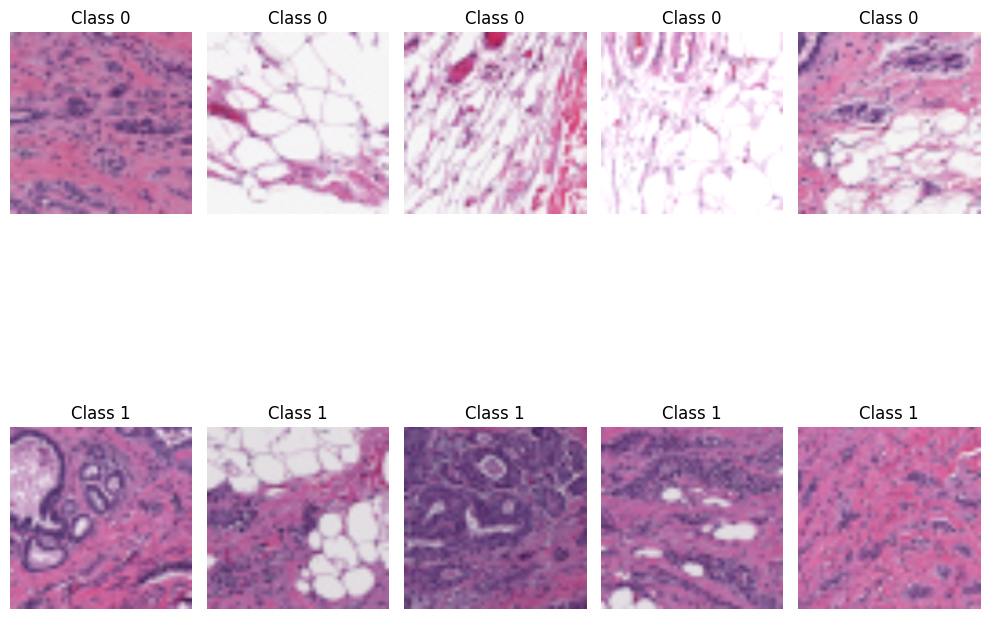

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_images(dataset, n_images_per_class):
    plt.figure(figsize=(10, 10))
    class_0 = []
    class_1 = []

    for images, labels in dataset.take(n_images_per_class * 500):  # Increase the number to ensure finding enough examples
        image = tf.squeeze(images, axis=0)
        label = tf.squeeze(labels, axis=0)
        label_class = tf.argmax(label).numpy()

        if label_class == 0 and len(class_0) < n_images_per_class:
            class_0.append(image.numpy())
        elif label_class == 1 and len(class_1) < n_images_per_class:
            class_1.append(image.numpy())

        if len(class_0) == n_images_per_class and len(class_1) == n_images_per_class:
            break

    total_images = len(class_0) + len(class_1)
    if total_images < 2 * n_images_per_class:
        print(f"Found only {len(class_0)} images of class 0 and {len(class_1)} images of class 1.")
        print("Not enough images to display. Check class distribution or increase the take amount in dataset.")

    # Plotting images from both classes
    for i, img in enumerate(class_0 + class_1):
        plt.subplot(2, n_images_per_class, i + 1)
        plt.imshow(img)
        plt.title('Class 0' if i < n_images_per_class else 'Class 1')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming 'dataset' is already loaded and prepared
batched_dataset = dataset.batch(1)  # Ensure the dataset is batched
visualize_images(batched_dataset, n_images_per_class=5)


In [5]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np

def calculate_class_weights(dataset):
    # Assume labels are one-hot encoded and dataset is not batched
    labels = []
    for _, label in dataset:
        labels.append(np.argmax(label.numpy()))  # Decode one-hot to class index

    # Calculate class weights
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(labels),
        y=labels
    )
    
    # Convert class weights to a dictionary to pass to model.fit
    class_weight_dict = dict(enumerate(class_weights))
    return class_weight_dict

# Example usage
dataset = load_dataset(augment=True)  # Ensure this loads the dataset without batching
class_weights = calculate_class_weights(dataset)
print("Class Weights:", class_weights)


Class Weights: {0: 0.6982157413277783, 1: 1.761251999086132}


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_model(backbone_name='EfficientNetV2B0', input_shape=(224, 224, 3), num_classes=2):
    # Dictionary of available backbones
    backbones = {
        'EfficientNetV2B0': EfficientNetV2B0,
        'EfficientNetV2B1': EfficientNetV2B1,
        'MobileNetV2': MobileNetV2,
        'InceptionV3': InceptionV3,
        'ResNet50': ResNet50
    }

    # Select the backbone model
    BackboneModel = backbones[backbone_name]
    backbone = BackboneModel(include_top=False, input_shape=input_shape, weights='imagenet')
    backbone.trainable = True

    # Build the model
    inputs = layers.Input(shape=input_shape)
    x = backbone(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Example: Build and compile the model with EfficientNetV2B0
model_eff_net_b0 = build_model('EfficientNetV2B0')
model_eff_net_b0.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921,874 (22.59 MB)

 Trainable params: 5,861,266 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
# Assuming train_dataset and val_dataset are predefined
history_eff_net_b0 = model_eff_net_b0.fit(train_dataset, epochs=100,
                                        validation_data=val_dataset, 
                                          callbacks=[reduce_lr, early_stopping],
                                         class_weight = class_weights)


Epoch 1/100


I0000 00:00:1718445825.590602    3449 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718445825.726339    3449 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3535/6939 ━━━━━━━━━━━━━━━━━━━━ 6:35 116ms/step - accuracy: 0.8946 - loss: 0.2769

In [13]:
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)  # Expected: (batch_size, 224, 224, 3)
    print("Label batch shape:", labels.shape)  # Expected: (batch_size, 2)

    

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 2)
